# 01 CNN Training With Code Example - Neural Network Programming Course

## CNN Training Process
**In this episode, we will learn the steps needed to train a convolutional neural network.**  

So far in this series, we learned about Tensors, and we've learned all about PyTorch neural networks. We are now ready to begin the **training process**.
* Prepare the data
* Build the model
* Train the model
  * **Calculate the loss, the gradient, and update the weights**
* Analyze the model's results

## Training: What We Do After The Forward Pass

During training, we do a forward pass, but then what? We'll suppose we get a batch and pass it forward through the network. Once the output is obtained, we compare the **predicted output** to the **actual labels**, and once we know **how close** the predicted values are from the actual labels, we **tweak** the weights inside the network in such a way that the values the network predicts move closer to the true values (labels).其实就是通过loss function找最优解  

All of this is for **a single batch**, and we **repeat** this process for **every batch** until we have covered every sample in our training set. After we've completed this process for all of the batches and passed over every sample in our **training set**, we say that **an epoch** is complete. We use the word **epoch** to represent a **time period** in which our **entire training** set has been covered.

During the **entire training process**, we do as many **epochs** as necessary to reach our desired level of accuracy. With this, we have the following steps:
1. Get batch from the training set.
2. Pass batch to network.
3. Calculate the loss (difference between the predicted values and the true values).
4. Calculate the gradient of the loss function w.r.t the network's weights.
5. Update the weights using the gradients to reduce the loss.
6. Repeat steps 1-5 until one epoch is completed.
7. Repeat steps 1-6 for as many epochs required to reach the minimum loss.

We already know exactly how to do steps `1` and `2`. We use a loss function to perform step `3`, and you know that we use `backpropagation` and an optimization algorithm to perform step `4` and `5`. Steps `6` and `7` are just standard **Python loops (the training loop)**. Let's see how this is done in code.

## The Training Process

Since we disabled PyTorch's gradient tracking feature in a previous episode, we need to be sure to turn it back on (it is on by default).  
`torch.set_grad_enabled(True)`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) # Display options for output
torch.set_grad_enabled(True) # Already on by default


In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.6.0
0.7.0


In [3]:
def get_num_correct(preds,labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

### Preparing For The Forward Pass
We already know how to get a batch and pass it forward through the network. Let's see what we do after the forward pass is complete.

We'll begin by:
1. Creating an instance of our `Network` class.
2. Creating a data loader that provides batches of size 100 from our training set.
3. Unpacking the images and labels from one of these batches.

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size = 5)
        
        self.fc1 = nn.Linear(in_features = 12*4*4,out_features = 120)
        self.fc2 = nn.Linear(in_features = 120,out_features = 60)
        self.out = nn.Linear(in_features = 60,out_features = 10)
        
    def forward(self,t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST'
    ,train = True
    ,download = True
    ,transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [6]:
network = Network()

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader)) # Getting a batch
images, labels = batch

Next, we are ready to pass our batch of images forward through the network and obtain the output predictions. Once we have the prediction tensor, we can use the predictions and the true labels to calculate the loss.

### Calculating The Loss
To do this we will use the `cross_entropy()` loss function that is available in PyTorch's `nn.functional` API. Once we have the loss, we can print it, and also check the number of correct predictions using the function we created a [previous post](https://github.com/unclestrong/DeepLearning-code/blob/master/05%20Neural%20Networks%20and%20PyTorch%20Design-P2.ipynb).

In [8]:
preds = network(images)
loss = F.cross_entropy(preds,labels) # Calculating the loss

In [9]:
loss.item()

2.307081460952759

In [10]:
get_num_correct(preds,labels)

11

The `cross_entropy()` function returned a scalar valued tenor, and so we used the `item()` method to print the `loss` as a Python number. We got `11` out of `100` correct, and since we have `10` prediction classes, this is what we'd expect by guessing at random.

### Calculating The Gradients
Calculating the gradients is very easy using PyTorch. Since our network is a PyTorch `nn.Module`, PyTorch has created a **computation graph** under the hood. As our tensor flowed forward through our network, all of the computations where added to the graph. The computation graph is then used by PyTorch to calculate the gradients of the loss function with respect to the network's weights.

Before we calculate the gradients, let's verify that we **currently** have **no gradients** inside our `conv1` layer. The gradients are tensors that are accessible in the `grad` (short for gradient) attribute of the weight tensor of each layer.

In [12]:
print(network.conv1.weight.grad)

None


To `calculate the gradients`, we call the `backward()` method on the loss tensor, like so:

In [13]:
loss.backward() # Calculating the gradients

Now, the gradients of the loss function have been stored inside weight tensors.

In [14]:
network.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

In [15]:
network.conv1.weight.grad

tensor([[[[ 8.0532e-04,  7.1517e-04,  5.4289e-04,  4.2453e-04,  2.2062e-04],
          [ 4.2473e-04,  3.6081e-04,  3.4775e-04,  3.3520e-04,  1.3792e-04],
          [ 1.8878e-04,  2.0218e-04,  1.3977e-04,  3.1463e-05, -1.6695e-04],
          [ 6.2114e-06,  1.1477e-04,  4.5907e-05, -2.9935e-05, -1.2944e-04],
          [-2.1969e-04, -1.8537e-04, -2.5566e-04, -2.2936e-04, -2.4350e-04]]],


        [[[ 1.0334e-03, -1.3228e-04, -4.6828e-04,  7.5834e-04,  1.1306e-03],
          [ 7.5262e-04, -4.0342e-04, -9.5859e-04,  1.9084e-04,  6.4649e-04],
          [ 6.9752e-04, -2.2768e-04, -8.4701e-04,  3.4626e-04,  4.3055e-04],
          [ 3.6175e-04, -7.0846e-04, -1.4202e-03, -3.4338e-04, -2.2465e-04],
          [ 3.8891e-04, -5.8086e-04, -1.4649e-03, -5.2291e-04, -2.1644e-04]]],


        [[[-2.7583e-03, -2.3309e-03, -2.3823e-03, -2.7402e-03, -2.4740e-03],
          [-2.3130e-03, -1.8277e-03, -2.0964e-03, -2.7168e-03, -2.2019e-03],
          [-2.1739e-03, -1.8778e-03, -2.1596e-03, -2.5166e-03, -1.98

These gradients are used by the optimizer to update the respective weights. To create our optimizer, we use the `torch.optim` package that has many optimization algorithm implementations that we can use. We'll use `Adam` for our example.

### Updating The Weights
To the `Adam` class constructor, we pass the `network parameters` (this is how the optimizer is able to access the gradients), and we pass the `learning rate` .

Finally, all we have to do to update the weights is to tell the optimizer to use the gradients to step in the direction of the loss function's minimum.

In [16]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step() # Updating the weights

When the `step()` function is called, the optimizer updates the weights using the gradients that are stored in the network's parameters. This means that we should expect our loss to be reduced if we pass the same batch through the network again. Checking this, we can see that this is indeed the case:

In [17]:
preds = network(images)
loss.item()

2.307081460952759

In [19]:
loss = F.cross_entropy(preds, labels)
loss.item()

2.2812142372131348

In [20]:
get_num_correct(preds, labels)

11

## Train Using A Single Batch
We can summarize the code for training with a single batch in the following way:

In [21]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.300954818725586
loss2: 2.2833118438720703


## Quiz 01
Q1:During the training process, once the output is obtained, we compare the predicted output to the _______________.<br>
A1:labels

Q2:Once we know how close the predicted values are to the actual labels, we tweak the weights inside the network in such a way that the predicted values move _______________ the true values (labels).  
A2:closer to

Q3:After we've completed the training process for all the batches in our training set, we say that _______________ is complete.  
A3:an epoch

Q4:During the training process, we use the word _______________ to represent a time period for which the entire training set (every batch) has been passed to the network.
A4:epoch  

Q5:During the entire training process, we do as many epochs as necessary to reach the _______________.<br>
A5:minimum loss

Q6:To begin the training process, the first step is to get a batch from the training set. What is the second step?  
A6:Pass the obtained batch to the network.

Q7:During the training process, after we pass a batch to the network, we use the predicted values and the labels to _______________.<br>
A7:calculate the loss

Q8:PyTorch's gradient tracking feature is turned on using which piece of code?  
A8:torch.set_grad_enabled(True)

Q9:Which piece of code makes the most sense for creating a PyTorch DataLoader?  
A9:torch.utils.data.DataLoader(train_set)

Q10:The cross_entropy() loss function lives in which PyTorch package?  
A10:torch.nn.functional

---
---

# 02 CNN Training Loop Explained - Neural Network Code Project
## CNN Training Loop - Teach A Neural Network
**In this episode, we will learn how to build the training loop for a convolutional neural network using Python.**


In the last episode, we learned that the [training process](https://deeplizard.com/learn/video/sZAlS3_dnk0) is an iterative process, and to train a neural network, we build what is called the training loop.
* Prepare the data
* Build the model
* Train the model
  * Build the training loop
* Analyze the model's results

### Training With A Single Batch
We can summarize the code for training with a single batch in the following way:
```python
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())
```

### Output:
```python
loss1: 2.300954818725586
loss2: 2.2833118438720703
```

One thing that you'll notice is that we get **different results each time** we run this code. This is because the model is created each time at the top, and we know from previous posts that the model weights are **randomly initialized**.

### Training With All Batches (Single Epoch)
Now, to train with all of the **batches** available inside our **data loader**, we need to make a few changes and add one additional line of code:

In [22]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader: # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: 46957 loss: 347.39798778295517


Instead of getting a single batch from our data loader, we'll create a for loop that will **iterate** over **all of the batches**.

Since we have `60,000` samples in our training set, we will have `60,000 / 100 = 600` iterations. For this reason, we'll remove the print statement from within the loop, and keep track of the `total loss` and the `total number` of correct predictions printing them at the end.

Something to notice about these `600` iterations is that our `weights` will be `updated 600 times` by the end of the loop. If we **raise the batch_size** this number will **go down** and if we **lower the batch_size** this number will **go up**.

Finally, after we call the `backward()` method on our loss tensor, we know the gradients will be calculated and **added** to the `grad` attributes of our network's parameters. For this reason, we need to zero out these gradients. We can do this with a method called `zero_grad()` that comes with the optimizer.

We are ready to run this code. This time the code will take longer because the loop is working on `600` batches.

```python
epoch: 0 total_correct: 46957 loss: 347.39798778295517
```

We get the results, and we can see that the total number correct out of 60,000 was 46,957.

In [23]:
total_correct / len(train_set)

0.7826166666666666

That's pretty good after only one epoch (a single full pass over the data). Even though we did one epoch, we still have to keep in mind that the **weights** were updated `600` times, and this fact depends on our batch size. If made our batch_batch size larger, say `10,000`, the weights would only be updated `6` times, and the results **wouldn't be quite as good**.

### Training With Multiple Epochs
To do **multiple epochs**, all we have to do is put this code into a **for loop**. We'll also add the epoch number to the print statement.

In [24]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 46928 loss: 344.27279521524906
epoch 1 total_correct: 51277 loss: 232.71748647093773
epoch 2 total_correct: 52081 loss: 208.65398114919662
epoch 3 total_correct: 52609 loss: 194.9983945786953
epoch 4 total_correct: 52906 loss: 190.74674943089485
epoch 5 total_correct: 53021 loss: 186.76688426733017
epoch 6 total_correct: 53290 loss: 181.0335234105587
epoch 7 total_correct: 53226 loss: 180.50387901067734
epoch 8 total_correct: 53480 loss: 173.91857013106346
epoch 9 total_correct: 53588 loss: 170.3671340867877


## Complete Training Loop
Putting all of this together, we can pull the `network`, `optimizer`, and the `train_loader` out of the training loop cell.
```python
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)
```
This makes it so that we can run the training loop without resetting the networks weights.
```python
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )
```

## Quiz 02
Q1:In the code below, what does the `lr` parameter do?
```python
optimizer = optim.Adam(network.parameters(), lr=0.01)
```
A1:sets the learning rate which tells the optimizer how far to step in the direction of the loss function's minimum

Q2:After we call the `backward()` method on our loss tensor, the gradients will be calculated and _______________ of our network's parameters.  
A2:added to the grad attributes

Q3:Using the code below, determine how many times optimizer.step() will be called during this training loop run.
```python
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):
    for batch in train_loader: # Get Batch
        images, labels = batch
        # other stuff happens
        optimizer.step() # Update Weights
```
A3:6000

Q4:Suppose we have a fixed training set size. As batch size goes up, which of the following happens inside each epoch?
```python
for epoch in range(10):
    # what happens in here?
```
A4:the frequency of weight updates goes down

Q5:Suppose that our training set contains `60000 `samples. If we are using the data loader below, how many times will our weights be updated during one epoch?
```python
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
```
A5:6

Q6:Suppose that our training set contains `60000` samples. If we are using the data loader below, how many iterations will occur inside our `for batch in train_loader:` loop?
```python
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
```
A6:60

Q7:Suppose that our training set contains `60000` samples. If we are using the data loader below, how many iterations will occur inside our `for batch in train_loader:` loop?
```python
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
```
A7:600

Q8:What is the result of running the line of code below?  
```python
loss.item()
```
A8:the loss as a Python number

---
---

# 03 CNN Confusion Matrix With PyTorch - Neural Network Programming

## Create A Confusion Matrix With PyTorch
**In this episode, we're going to build some functions that will allow us to get a prediction tensor for every sample in our training set.**

Then, we'll see how we can take this **prediction tensor**, along with the **labels** for each sample, to create a **confusion matrix**. This confusion matrix will allow us to see which **categories** our network is confusing with one another. 

Where we are now in the course.
* Prepare the data
* Build the model
* Train the model
* Analyze the model's results
  * **Building, plotting, and interpreting a confusion matrix**
  
Be sure to see the previous episode in this course for all the code setup details.

## Interpreting The Confusion Matrix
![Confusion Matrix](https://deeplizard.com/images/fashion%20mnist%20confusion%20matrix.png)
The confusion matrix has three axes:
1. Prediction label (class)
2. True label
3. Heat map value (color)

The **prediction label** and **true labels** show us which prediction class we are dealing with. The **matrix diagonal** represents locations in the matrix where the **prediction and the truth are the same**, so this is where we want the **heat map** to be **darker**.

Any values that are **not on the diagonal** are **incorrect** predictions because the prediction and the true label don't match. To read the plot, we can use these steps:
1. Choose a prediction label on the **horizontal axis**.
2. Check the **diagonal location** for this label to see the **total number correct**.
3. Check the other **non-diagonal locations** to see where the network is **confused**.

For example, the network is confusing a T-shirt/top with a shirt, but is not confusing the T-shirt/top with things like:
* Ankle boot
* Sneaker
* Sandal
If we think about it, this **makes pretty good sense**. As our model learns, we will see the numbers that lie **outside the diagonal** become smaller and **smaller**.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) # Display options for output
torch.set_grad_enabled(True) # Already on by default

In [2]:
def get_num_correct(preds,labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size = 5)
        
        self.fc1 = nn.Linear(in_features = 12*4*4,out_features = 120)
        self.fc2 = nn.Linear(in_features = 120,out_features = 60)
        self.out = nn.Linear(in_features = 60,out_features = 10)
        
    def forward(self,t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST'
    ,train = True
    ,download = True
    ,transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
network = Network()

In [6]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)

In [7]:
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 46100 loss: 362.7832463532686
epoch 1 total_correct: 51150 loss: 238.03466223180294
epoch 2 total_correct: 51779 loss: 219.40091614425182
epoch 3 total_correct: 52221 loss: 208.4118372797966
epoch 4 total_correct: 52519 loss: 201.381635800004
epoch 5 total_correct: 52650 loss: 198.1756061464548
epoch 6 total_correct: 52792 loss: 192.37248916924
epoch 7 total_correct: 53051 loss: 188.6718685477972
epoch 8 total_correct: 53030 loss: 189.43409553170204
epoch 9 total_correct: 53139 loss: 185.44945441186428


## Confusion Matrix Requirements

To create a **confusion matrix** for our entire dataset, we need to have a **prediction tensor** with a single dimension that has the **same length** as our **training set**.

In [8]:
len(train_set)

60000

This **prediction tensor** will contain ten predictions for each sample from our training set (one for each category of clothing). After we have obtained this tensor, we can use the **labels tensor** to generate a confusion matrix.

In [9]:
len(train_set.targets)

60000

A **confusion matrix** will show us where the model is getting confused. To be more specific, the confusion matrix will show us which **categories** the model is predicting **correctly** and which categories the model is predicting **incorrectly**. For the incorrect predictions, we will be able to see which category the model predicted, and this will show us which categories are confusing the model.

## Get Predictions For The Entire Training Set
To get the **predictions** for all the **training set samples**, we need to pass all of the samples forward through the network. To do this, it is possible to create a `DataLoader` that has `batch_size=1`. This will pass a single batch to the network at once and will give us the desired **prediction tensor** for all the training set samples.

However, depending on the **computing resources** and the **size of the training set** if we were training on a different data set, we need a way to prediction on **smaller batches** and **collect the results**. To collect the results, we'll use the `torch.cat()` function to **concatenate** the output tensors together to obtain our **single prediction tensor**. Let's build a function to do this.

### Building A Function To Get Predictions For ALL Samples
We'll create a function called `get_all_preds()`, and we'll pass a **model** and a **data loader**. The **model** will be used to **obtain the predictions**, and the **data loader** will be used to **provide the batches from the training set**.

All the function needs to do is **iterate** over the **data loader** passing the batches to the model and **concatenating** the results of each batch to **a prediction tensor** that will returned to the caller.

In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

The implantation of this function creates an **empty tensor**, `all_preds` to hold the **output predictions**. Then, it **iterates** over the batches coming from the **data loader**, and **concatenates** the output predictions with the **all_preds tensor**. Finally, **all the predictions**, all_preds, is returned to the caller.

Note at the **top**, we have annotated the function using the `@torch.no_grad()` PyTorch decoration. This is because we want this functions execution to **omit gradient tracking**.

This is because **gradient tracking** uses **memory**, and during inference (getting predictions while not training) there is **no need** to keep track of the computational graph. The decoration is **one way** of **locally turning off** the gradient tracking feature while executing specific functions.

### Locally Disabling PyTorch Gradient Tracking
We are ready now to make the call to obtain the predictions for the training set. All we need to do is create a **data loader** with a reasonable **batch size**, and pass the model and data loader to the `get_all_preds()` function.

In a previous episode, we saw how use turned off PyTorch's **gradient tracking** feature when it was not needed, and we turned it back on when we started the training process.

We specifically **need the gradient** calculation feature anytime we are going to calculate gradients using the `backward()` function. Otherwise, it is a good idea to turn it **off** because having it off will **reduce memory consumption** for computations, e.g. when we are using networks for **predicting** (inference).

We can disable gradient computations for **specific** or **local** spots in our code, e.g. like what we just saw with the annotated function. As another example, we can use Python's `with` context manger keyword to specify that a specify block of code should exclude gradient computations.

Both of these options are valid.

In [11]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

### Using The Predictions Tensor
Now, that we have the **prediction tensor**, we can pass it to the `get_num_correct()` function that we created in a previous episode, along with the **training set labels**, to get the **total number of correct predictions**.

We can see the total number of correct predictions and print the accuracy by dividing by the number of samples in the training set.

In [13]:
preds_correct = get_num_correct(train_preds, train_set.targets)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 53262
accuracy: 0.8877


## Building The Confusion Matrix
Our task in building the confusion matrix is to **count** the number of **predicted values** against the **true values** (targets).

This will create a matrix that acts as a **heat map** telling us where the predicted values fall relative to the true values.

To do this, we need to have the `targets` tensor and the predicted label from the `train_preds` tensor.

In [14]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [15]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

Now, if we **compare** the two tensors **element-wise**, we can see if the predicted label matches the target. Additionally, if we are counting the number of predicted labels vs the target labels, the values inside the two tensors act as coordinates for our matrix. Let's **stack** these two tensors along the second dimension so we can have 60,000 **ordered pairs**.

In [16]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [17]:
stacked.shape

torch.Size([60000, 2])

In [18]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [19]:
stacked[0].tolist()

[9, 9]

Now, we can **iterate** over these **pairs** and **count** the number of **occurrences** at each position in the matrix. Let's create the matrix. Since we have ten prediction categories, we'll have a ten by ten matrix. Check [here](https://deeplizard.com/learn/video/kF2AlpykJGY) to learn about the `stack()` function.

In [20]:
cmt = torch.zeros(10,10, dtype=torch.int64)

In [21]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Now, we'll **iterate** over the prediction-target pairs and add one to the value inside the matrix each time the particular position occurs.

In [22]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [30]:
cmt

tensor([[5227,   10,   84,  123,   15,   10,  508,    0,   23,    0],
        [   7, 5899,    2,   82,    3,    0,    5,    0,    2,    0],
        [  68,    8, 4816,   48,  628,    3,  413,    0,   16,    0],
        [ 186,   76,   31, 5292,  304,    0,  105,    0,    3,    3],
        [  14,    9,  463,  102, 5146,    0,  236,    0,   30,    0],
        [   0,    3,    0,    0,    1, 5913,    1,   41,    2,   39],
        [ 931,   16,  412,  136,  555,    2, 3923,    1,   24,    0],
        [   0,    0,    0,    0,    0,  223,    0, 5379,    2,  396],
        [  16,    4,   28,   21,   15,   57,   60,   11, 5784,    4],
        [   0,    0,    0,    0,    0,   45,    0,   67,    5, 5883]])

In [29]:
cmt.numpy()

array([[5227,   10,   84,  123,   15,   10,  508,    0,   23,    0],
       [   7, 5899,    2,   82,    3,    0,    5,    0,    2,    0],
       [  68,    8, 4816,   48,  628,    3,  413,    0,   16,    0],
       [ 186,   76,   31, 5292,  304,    0,  105,    0,    3,    3],
       [  14,    9,  463,  102, 5146,    0,  236,    0,   30,    0],
       [   0,    3,    0,    0,    1, 5913,    1,   41,    2,   39],
       [ 931,   16,  412,  136,  555,    2, 3923,    1,   24,    0],
       [   0,    0,    0,    0,    0,  223,    0, 5379,    2,  396],
       [  16,    4,   28,   21,   15,   57,   60,   11, 5784,    4],
       [   0,    0,    0,    0,    0,   45,    0,   67,    5, 5883]],
      dtype=int64)

## Plotting The Confusion Matrix
To generate the actual confusion matrix as a `numpy.ndarray`, we use the `confusion_matrix()` function from the `sklearn.metrics library`. Let's get this imported along with our other needed imports.

In [24]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [25]:
# We can generate the confusion matrix like so:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [26]:
cm

array([[5227,   10,   84,  123,   15,   10,  508,    0,   23,    0],
       [   7, 5899,    2,   82,    3,    0,    5,    0,    2,    0],
       [  68,    8, 4816,   48,  628,    3,  413,    0,   16,    0],
       [ 186,   76,   31, 5292,  304,    0,  105,    0,    3,    3],
       [  14,    9,  463,  102, 5146,    0,  236,    0,   30,    0],
       [   0,    3,    0,    0,    1, 5913,    1,   41,    2,   39],
       [ 931,   16,  412,  136,  555,    2, 3923,    1,   24,    0],
       [   0,    0,    0,    0,    0,  223,    0, 5379,    2,  396],
       [  16,    4,   28,   21,   15,   57,   60,   11, 5784,    4],
       [   0,    0,    0,    0,    0,   45,    0,   67,    5, 5883]],
      dtype=int64)

PyTorch tensors are [array-like](https://numpy.org/doc/stable/user/basics.creation.html#converting-python-array-like-objects-to-numpy-arrays) Python objects, so we can pass them directly to the `confusion_matrix()` function. We pass the training set **labels tensor** (targets) and the **argmax** with respect to the first dimension of the train_preds tensor, and this gives us the confusion matrix data structure.

To actually plot the confusion matrix, we need some custom code that called `plot_confusion_matrix()`.

In [31]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We are ready to **plot** the confusion matrix, but first we need to create a **list** of prediction **class names** to pass to the `plot_confusion_matrix()` function. Our prediction classes and their corresponding indexes are given by the table below:

| **Index** | **Label** |
| --- | --- |
| 0 | 	T-shirt/top |
| 1 | 	Trouser |
| 2 | 	Pullover |
| 3 | 	Dress |
| 4 | 	Coat |
| 5 | 	Sandal |
| 6 | 	Shirt |
| 7 | 	Sneaker |
| 8 | 	Bag |
| 9 | 	Ankle boot |

![class](https://deeplizard.com/images/fashion%20mnist%20grid%20sample.png)


In [32]:
# This allows us to make the call to plot the matrix:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Confusion matrix, without normalization
[[5227   10   84  123   15   10  508    0   23    0]
 [   7 5899    2   82    3    0    5    0    2    0]
 [  68    8 4816   48  628    3  413    0   16    0]
 [ 186   76   31 5292  304    0  105    0    3    3]
 [  14    9  463  102 5146    0  236    0   30    0]
 [   0    3    0    0    1 5913    1   41    2   39]
 [ 931   16  412  136  555    2 3923    1   24    0]
 [   0    0    0    0    0  223    0 5379    2  396]
 [  16    4   28   21   15   57   60   11 5784    4]
 [   0    0    0    0    0   45    0   67    5 5883]]


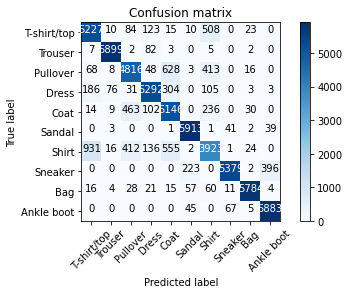

In [33]:
plot_confusion_matrix(cm, train_set.classes)

## Quiz 03
Q1:In deep learning, another name for labels is _______________.<br>
A1:targets

Q2:To build a confusion matrix, we use a rank _______________ tensor.  
A2:two

Q3:Using the fact that this confusion matrix was built using the entire FashionMNIST training set, what will be the result of calling `cmt.sum()`?
```python
> cmt
tensor([
    [5637,    3,   96,   75,   20,   10,   86,    0,   73,    0],
    [  40, 5843,    3,   75,   16,    8,    5,    0,   10,    0],
    [  87,    4, 4500,   70, 1069,    8,  156,    0,  106,    0],
    [ 339,   61,   19, 5269,  203,   10,   72,    2,   25,    0],
    [  23,    9,  263,  209, 5217,    2,  238,    0,   39,    0],
    [   0,    0,    0,    1,    0, 5604,    0,  333,   13,   49],
    [1827,    7,  716,  104,  792,    3, 2370,    0,  181,    0],
    [   0,    0,    0,    0,    0,   22,    0, 5867,    4,  107],
    [  32,    1,   13,   15,   19,    5,   17,   11, 5887,    0],
    [   0,    0,    0,    0,    0,   28,    0,  234,    6, 5732]
])
```
A3:60000

Q4:Using the code below, how many of the predictions inside the `preds` tensor are correct?
```python
> train_set.targets
tensor([9, 0, 0, 3, 0, 5])

> preds.argmax(dim=1)
tensor([9, 0, 5, 4, 0, 5])
```
A4:4

Q5:_______________ is branch of philosophy concerned with the theory of knowledge.  
A5:Epistemology

---
---